## Importation des librairies

In [1]:
%%capture capt
!pip install lifelines
!pip install tqdm
!pip install numpy==1.22
from tqdm import tqdm
import numpy as np
import pandas as pd
from lifelines.statistics import proportional_hazard_test
from lifelines.statistics import logrank_test
from lifelines import KaplanMeierFitter
from matplotlib import pyplot as plt
from lifelines import CoxPHFitter
from sklearn.model_selection import train_test_split
import statsmodels.stats.diagnostic as diag

## Base Tristan

## Test log-rank

In [2]:
profil_patient=pd.read_csv("../data/profil_patient.csv")
profil_patient['CHOC']=profil_patient['CHOC'].astype(int)
profil_patient['y_nais']=2016-profil_patient['y_nais']
#Nb_jours_moyen=Nombre de jours hospitalisé / Nombre de séjours
#Moyenne empirique du nombre de jours hospitalisé
profil_patient['Nb_jours_moyen']=profil_patient['Nb_jours_sej']/profil_patient['Nb_hospit']
profil_patient.head()

,CODE_PATIENT,date_h0,y_nais,BEN_RES_DPT,BEN_SEX_COD,dte_deces,Mort,Nb_survie,Nb_hospit,CHOC,Nb_jours_sej,cat_age,cat_nb_hospit,cat_nb_jours_sej,cluster,Nb_jours_moyen
0,P0,2011-11-22,67,11,1,NaN,False,2596,9,0,23,1,1,1,0,2.555556
1,P6,2013-12-05,87,14,2,2015-03,True,456,8,0,51,2,1,1,1,6.375000
2,P8,2015-07-02,49,54,2,2015-08,True,41,3,1,43,0,1,1,2,14.333333
3,P13,2011-05-19,57,974,1,NaN,False,2783,2,0,3,0,1,0,3,1.500000
4,P16,2010-03-18,69,76,1,NaN,False,3210,9,0,28,1,1,1,0,3.111111


### Age plutôt que l'année de naissance

In [3]:
profil_patient['y_nais'].describe()

count    10051.000000
mean        81.396378
std         13.536605
min         19.000000
25%         74.000000
50%         85.000000
75%         91.000000
max        109.000000
Name: y_nais, dtype: float64

### Nombre de jours moyen plutôt que les deux variables d'hospitalisation : empêcher la multi-colinéarité

In [4]:
profil_patient['Nb_jours_moyen'].describe()

count    10051.000000
mean         7.799798
std          6.016516
min          0.000000
25%          4.200000
50%          6.666667
75%          9.949495
max        224.000000
Name: Nb_jours_moyen, dtype: float64

### Entre cluster

Text(0.5, 1.0, 'p-valeur du test de nullité log-rank inter-clusters')

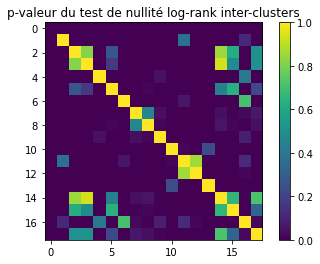

In [5]:
Matrice=np.zeros((18,18))
for i in range (1,18):
    for j in range (1,18):
        cluster_i=i
        cluster_j=j
        results = logrank_test(profil_patient['Nb_survie'][profil_patient['cluster']==cluster_i], profil_patient['Nb_survie'][profil_patient['cluster']==cluster_j], event_observed_A=profil_patient['Mort'][profil_patient['cluster']==cluster_i], event_observed_B=profil_patient['Mort'][profil_patient['cluster']==cluster_j])
        Matrice[i,j]=results.p_value
plt.imshow(Matrice)
plt.colorbar()
plt.title("p-valeur du test de nullité log-rank inter-clusters")


Text(0.5, 1.0, 'p-valeur du test de nullité log-rank inter-clusters')

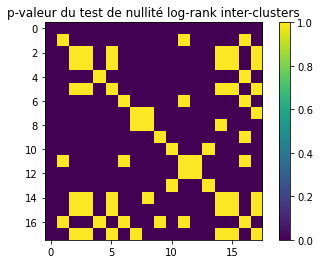

In [6]:
Matrice_seuil=1 *(Matrice>0.05)
plt.imshow(Matrice_seuil)
plt.colorbar()
plt.title("p-valeur du test de nullité log-rank inter-clusters")

### CHOC ou pas choc

p-valeur CHOC/PAS CHOC =
1.0571089917141666e-10


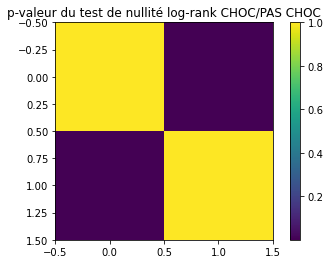

In [7]:
Matrice=np.zeros((2,2))
for i in range (0,2):
    for j in range (0,2):
        cluster_i=i
        cluster_j=j
        results = logrank_test(profil_patient['Nb_survie'][profil_patient['CHOC']==cluster_i], profil_patient['Nb_survie'][profil_patient['CHOC']==cluster_j], event_observed_A=profil_patient['Mort'][profil_patient['CHOC']==cluster_i], event_observed_B=profil_patient['Mort'][profil_patient['CHOC']==cluster_j])
        Matrice[i,j]=results.p_value
plt.imshow(Matrice)
plt.colorbar()
plt.title("p-valeur du test de nullité log-rank CHOC/PAS CHOC")
print("p-valeur CHOC/PAS CHOC =")
print(logrank_test(profil_patient['Nb_survie'][profil_patient['CHOC']==0], profil_patient['Nb_survie'][profil_patient['CHOC']==1], event_observed_A=profil_patient['Mort'][profil_patient['CHOC']==0], event_observed_B=profil_patient['Mort'][profil_patient['CHOC']==1]).p_value)

Text(0.5, 1.0, 'p-valeur du test de nullité log-rank CHOC/PAS CHOC')

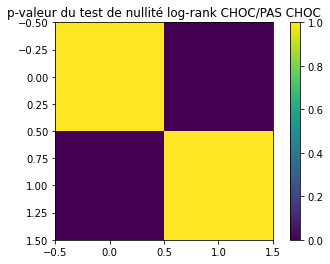

In [8]:
Matrice_seuil=1 *(Matrice>0.05)
plt.imshow(Matrice_seuil)
plt.colorbar()
plt.title("p-valeur du test de nullité log-rank CHOC/PAS CHOC")

### HOMME OU FEMME

p-valeur HOMME/FEMME =
0.004273345157189771


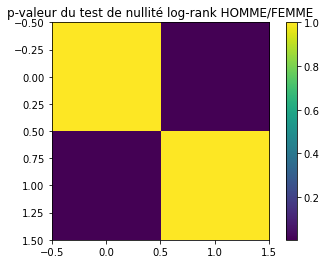

In [9]:
Matrice=np.zeros((2,2))
for i in range (0,2):
    for j in range (0,2):
        cluster_i=i+1
        cluster_j=j+1
        results = logrank_test(profil_patient['Nb_survie'][profil_patient['BEN_SEX_COD']==cluster_i], profil_patient['Nb_survie'][profil_patient['BEN_SEX_COD']==cluster_j], event_observed_A=profil_patient['Mort'][profil_patient['BEN_SEX_COD']==cluster_i], event_observed_B=profil_patient['Mort'][profil_patient['BEN_SEX_COD']==cluster_j])
        Matrice[i,j]=results.p_value
plt.imshow(Matrice)
plt.colorbar()
plt.title("p-valeur du test de nullité log-rank HOMME/FEMME")
print("p-valeur HOMME/FEMME =")
print(logrank_test(profil_patient['Nb_survie'][profil_patient['BEN_SEX_COD']==1], profil_patient['Nb_survie'][profil_patient['BEN_SEX_COD']==2], event_observed_A=profil_patient['Mort'][profil_patient['BEN_SEX_COD']==1], event_observed_B=profil_patient['Mort'][profil_patient['BEN_SEX_COD']==2]).p_value)

Text(0.5, 1.0, 'p-valeur du test de nullité log-rank CHOC/PAS CHOC')

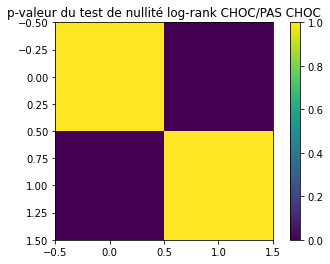

In [10]:
Matrice_seuil=1 *(Matrice>0.05)
plt.imshow(Matrice_seuil)
plt.colorbar()
plt.title("p-valeur du test de nullité log-rank CHOC/PAS CHOC")

### Test de base (sans stratification, sans pénalisation, sans spline)

In [11]:
profil_patient=pd.read_csv("../data/profil_patient.csv")
profil_patient['CHOC']=profil_patient['CHOC'].astype(int)
profil_patient['y_nais']=2016-profil_patient['y_nais']
#Nb_jours_moyen=Nombre de jours hospitalisé / Nombre de séjours
#Moyenne empirique du nombre de jours hospitalisé
profil_patient['Nb_jours_moyen']=profil_patient['Nb_jours_sej']/profil_patient['Nb_hospit']
profil_patient.head()

,CODE_PATIENT,date_h0,y_nais,BEN_RES_DPT,BEN_SEX_COD,dte_deces,Mort,Nb_survie,Nb_hospit,CHOC,Nb_jours_sej,cat_age,cat_nb_hospit,cat_nb_jours_sej,cluster,Nb_jours_moyen
0,P0,2011-11-22,67,11,1,NaN,False,2596,9,0,23,1,1,1,0,2.555556
1,P6,2013-12-05,87,14,2,2015-03,True,456,8,0,51,2,1,1,1,6.375000
2,P8,2015-07-02,49,54,2,2015-08,True,41,3,1,43,0,1,1,2,14.333333
3,P13,2011-05-19,57,974,1,NaN,False,2783,2,0,3,0,1,0,3,1.500000
4,P16,2010-03-18,69,76,1,NaN,False,3210,9,0,28,1,1,1,0,3.111111


In [12]:
data_train, data_test = train_test_split(profil_patient[['y_nais','BEN_SEX_COD','CHOC','Nb_jours_moyen','Nb_survie','Mort']], 
                                                    test_size=0.2, 
                                                    random_state=33)
                                                    #stratify = spooky_df['author_encoded'].values

In [13]:
data_train.head()

,y_nais,BEN_SEX_COD,CHOC,Nb_jours_moyen,Nb_survie,Mort
907,54,1,0,8.454545,226,True
8286,67,1,0,1.000000,1509,False
1276,88,2,0,5.800000,354,True
5022,95,2,0,8.142857,763,True
401,53,1,1,9.818182,236,True


In [14]:
cph = CoxPHFitter()
cph.fit(data_train, duration_col='Nb_survie', event_col='Mort')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 8040 total observations, 2737 right-censored observations>
             duration col = 'Nb_survie'
                event col = 'Mort'
      baseline estimation = breslow
   number of observations = 8040
number of events observed = 5303
   partial log-likelihood = -43957.45
         time fit was run = 2023-03-06 10:50:23 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
y_nais           0.04       1.04       0.00             0.04             0.05                 1.04                 1.05
BEN_SEX_COD     -0.21       0.81       0.03            -0.27            -0.15                 0.77                 0.86
CHOC             0.66       1.93       0.06             0.54             0.78                 1.71                 2.19
Nb_jours_moyen   0.02       1.02       0.00             0.02             0.02                 1.02                 1.02

                 cmp to     z      p   -log2(p)
covariate                                      
y_nais             0.00 31.48 <0.005     720.00
BEN_SEX_COD        0.00 -7.29 <0.005      41.55
CHOC               0.00 10.54 <0.005      83.91
Nb_jours_moyen     0.00 20.88 <0.005     319.17
---
Concordance = 0.64
Partial AIC = 87922.90
log-likelihood ratio test = 1457.21 on 4 df
-log2(p) of ll-ratio test = inf

Text(0, 0.5, 'Probabilité de survie')

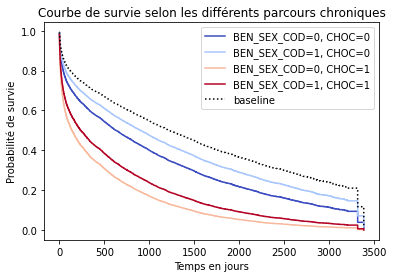

In [15]:
cph.plot_partial_effects_on_outcome(covariates=['BEN_SEX_COD','CHOC'], values=[(0,0),(1,0),(0,1),(1,1)], cmap='coolwarm')
plt.title("Courbe de survie selon les différents parcours chroniques")
plt.xlabel("Temps en jours")
plt.ylabel("Probabilité de survie")

<AxesSubplot:xlabel='log(HR) (95% CI)'>

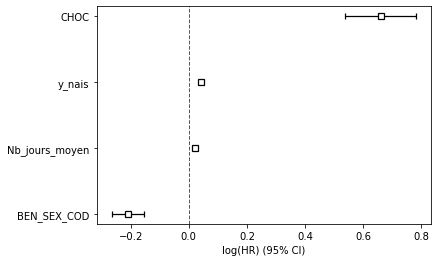

In [16]:
cph.plot()

Pour la variable y_nais:


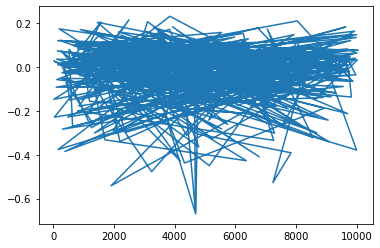

(array([63.2155125]), array([0.01109468]), array([62.97395123]), array([0.01169226]))
p-valeur du test de Ljung-Box: [0.01109468]
p-valeur du test de Box-Pierce test: [0.01169226]
Cela doit être plus grand que 0.05
Pour la variable BEN_SEX_COD:


D:\anaconda3\lib\site-packages\statsmodels\stats\diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


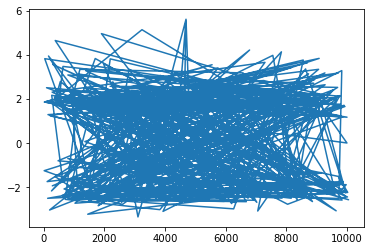

D:\anaconda3\lib\site-packages\statsmodels\stats\diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


(array([42.52722014]), array([0.36277479]), array([42.34545349]), array([0.37011826]))
p-valeur du test de Ljung-Box: [0.36277479]
p-valeur du test de Box-Pierce test: [0.37011826]
Cela doit être plus grand que 0.05
Pour la variable CHOC:


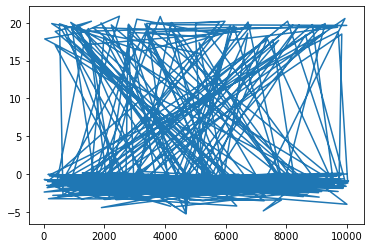

(array([273.21975338]), array([1.67727088e-36]), array([272.16608082]), array([2.64111905e-36]))
p-valeur du test de Ljung-Box: [1.67727088e-36]
p-valeur du test de Box-Pierce test: [2.64111905e-36]
Cela doit être plus grand que 0.05
Pour la variable Nb_jours_moyen:


D:\anaconda3\lib\site-packages\statsmodels\stats\diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


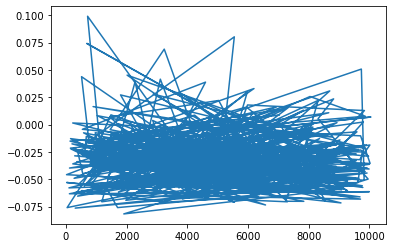

(array([1796.84297413]), array([0.]), array([1789.12398997]), array([0.]))
p-valeur du test de Ljung-Box: [0.]
p-valeur du test de Box-Pierce test: [0.]
Cela doit être plus grand que 0.05


D:\anaconda3\lib\site-packages\statsmodels\stats\diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


In [17]:
#Use Lifelines to calculate the variance scaled Schoenfeld residuals for all regression variables in one go:
scaled_schoenfeld_residuals = cph.compute_residuals(training_dataframe=data_train, kind='scaled_schoenfeld')
#print(scaled_schoenfeld_residuals)
Variables=['y_nais','BEN_SEX_COD','CHOC','Nb_jours_moyen']
for variable in Variables:
    print('Pour la variable ' + str(variable) + ':')
    #Let's plot the residuals for AGE against time:
    plt.plot(scaled_schoenfeld_residuals.index[:500], scaled_schoenfeld_residuals[variable][:500])
    plt.show()
    #Run the Ljung-Box test to test for auto-correlation in residuals up to lag 40
    result=diag.acorr_ljungbox(x=scaled_schoenfeld_residuals[variable], lags=[40], boxpierce=True, model_df=0, period=None, return_df=None)
    print(result)
    print('p-valeur du test de Ljung-Box: ' + str(result[1]))
    print('p-valeur du test de Box-Pierce test: ' + str(result[3]))
    print('Cela doit être plus grand que 0.05')

In [18]:
cph.check_assumptions(data_train, p_value_threshold=0.05, show_plots=False)

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 8040 total observations, 2737 right-censored observations>
         test_name = proportional_hazard_test

---
                     test_statistic      p  -log2(p)
BEN_SEX_COD    km              6.21   0.01      6.30
               rank            6.87   0.01      6.83
CHOC           km             29.57 <0.005     24.14
               rank           32.46 <0.005     26.30
Nb_jours_moyen km             52.31 <0.005     40.94
               rank           56.34 <0.005     43.90
y_nais         km             41.88 <0.005     33.26
               rank           45.07 <0.005     35.61



1. Variable 'y_nais' failed the non-proportional test: p-value is <5e-05.

   Advice 1: the functional form of the variable 'y_nais' might be incorrect. That is, there may be
non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'y_nais' using pd.cut, and then specify it in
`strata=['y_nais', ...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


2. Variable 'BEN_SEX_COD' failed the non-proportional test: p-value is 0.0088.

   Advice: with so few unique values (only 2), you can include `strata=['BEN_SEX_COD', ...]` in the
call in `.fit`. See documentation in link [E] below.

3. Variable 'CHOC' failed the non-proportional test: p-value is <5e-05.

   Advice: with so few unique values (only 2), you can 

[]

In [19]:
print("Vraisemblance en % (on la veut la plus grande possible) pour le dataset de train")
print(100*np.exp(cph.score(data_train)))
print("Vraisemblance en % (on la veut la plus grande possible) pour le dataset de test")
print(100*np.exp(cph.score(data_test)))

Vraisemblance en % (on la veut la plus grande possible) pour le dataset de train
0.42224301776282785
Vraisemblance en % (on la veut la plus grande possible) pour le dataset de test
1.1148775464651646


### Test de base ( sans stratification, avec pénalisation L2, sans spline)

In [20]:
profil_patient=pd.read_csv("../data/profil_patient.csv")
profil_patient['CHOC']=profil_patient['CHOC'].astype(int)
profil_patient['y_nais']=2016-profil_patient['y_nais']
#Nb_jours_moyen=Nombre de jours hospitalisé / Nombre de séjours
#Moyenne empirique du nombre de jours hospitalisé
profil_patient['Nb_jours_moyen']=profil_patient['Nb_jours_sej']/profil_patient['Nb_hospit']
profil_patient.head()

,CODE_PATIENT,date_h0,y_nais,BEN_RES_DPT,BEN_SEX_COD,dte_deces,Mort,Nb_survie,Nb_hospit,CHOC,Nb_jours_sej,cat_age,cat_nb_hospit,cat_nb_jours_sej,cluster,Nb_jours_moyen
0,P0,2011-11-22,67,11,1,NaN,False,2596,9,0,23,1,1,1,0,2.555556
1,P6,2013-12-05,87,14,2,2015-03,True,456,8,0,51,2,1,1,1,6.375000
2,P8,2015-07-02,49,54,2,2015-08,True,41,3,1,43,0,1,1,2,14.333333
3,P13,2011-05-19,57,974,1,NaN,False,2783,2,0,3,0,1,0,3,1.500000
4,P16,2010-03-18,69,76,1,NaN,False,3210,9,0,28,1,1,1,0,3.111111


In [25]:
data_train, data_test = train_test_split(profil_patient[['y_nais','BEN_SEX_COD','CHOC','Nb_jours_moyen','Nb_survie','Mort']], 
                                                    test_size=0.2, 
                                                    random_state=33)
                                                    #stratify = spooky_df['author_encoded'].values

In [27]:
data_train.head()

,y_nais,BEN_SEX_COD,CHOC,Nb_jours_moyen,Nb_survie,Mort
907,54,1,0,8.454545,226,True
8286,67,1,0,1.000000,1509,False
1276,88,2,0,5.800000,354,True
5022,95,2,0,8.142857,763,True
401,53,1,1,9.818182,236,True


In [29]:
cph = CoxPHFitter(penalizer=0.5,l1_ratio=0)
cph.fit(data_train, duration_col='Nb_survie', event_col='Mort')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 8040 total observations, 2737 right-censored observations>
             duration col = 'Nb_survie'
                event col = 'Mort'
                penalizer = 0.5
                 l1 ratio = 0
      baseline estimation = breslow
   number of observations = 8040
number of events observed = 5303
   partial log-likelihood = -44300.26
         time fit was run = 2023-03-06 10:53:49 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
y_nais           0.02       1.02       0.00             0.02             0.02                 1.02                 1.02
BEN_SEX_COD     -0.04       0.96       0.02            -0.08             0.00                 0.92                 1.00
CHOC             0.28       1.32       0.05             0.18             0.38                 1.20                 1.46
Nb_jours_moyen   0.02       1.02       0.00             0.02             0.02                 1.02                 1.02

                 cmp to     z      p   -log2(p)
covariate                                      
y_nais             0.00 23.21 <0.005     393.32
BEN_SEX_COD        0.00 -1.84   0.07       3.91
CHOC               0.00  5.56 <0.005      25.14
Nb_jours_moyen     0.00 16.29 <0.005     195.83
---
Concordance = 0.64
Partial AIC = 88608.52
log-likelihood ratio test = 771.59 on 4 df
-log2(p) of ll-ratio test = 547.99

Text(0, 0.5, 'Probabilité de survie')

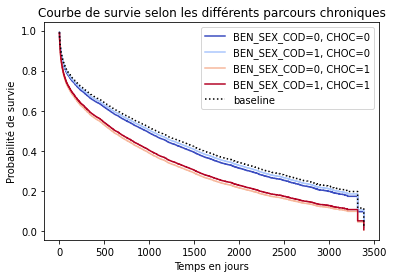

In [30]:
cph.plot_partial_effects_on_outcome(covariates=['BEN_SEX_COD','CHOC'], values=[(0,0),(1,0),(0,1),(1,1)], cmap='coolwarm')
plt.title("Courbe de survie selon les différents parcours chroniques")
plt.xlabel("Temps en jours")
plt.ylabel("Probabilité de survie")

<AxesSubplot:xlabel='log(HR) (95% CI)'>

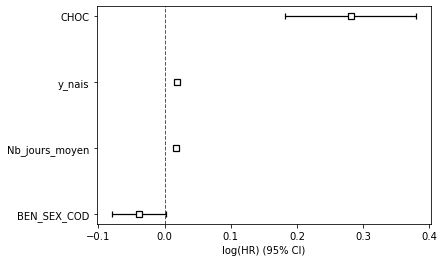

In [31]:
cph.plot()

Pour la variable y_nais:


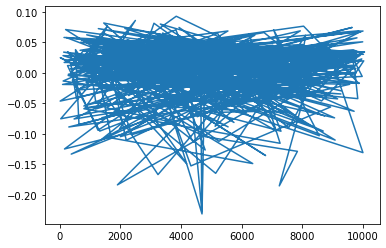

(array([71.60481177]), array([0.00156869]), array([71.33392757]), array([0.00167735]))
p-valeur du test de Ljung-Box: [0.00156869]
p-valeur du test de Box-Pierce test: [0.00167735]
Cela doit être plus grand que 0.05
Pour la variable BEN_SEX_COD:


D:\anaconda3\lib\site-packages\statsmodels\stats\diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


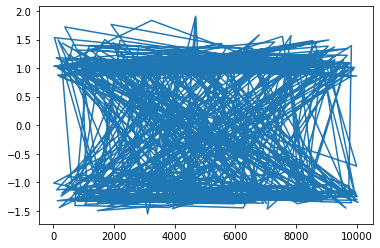

D:\anaconda3\lib\site-packages\statsmodels\stats\diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


(array([39.58518924]), array([0.4887717]), array([39.42910385]), array([0.49578032]))
p-valeur du test de Ljung-Box: [0.4887717]
p-valeur du test de Box-Pierce test: [0.49578032]
Cela doit être plus grand que 0.05
Pour la variable CHOC:


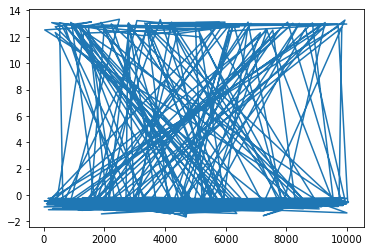

(array([318.41782079]), array([4.6080055e-45]), array([317.20725387]), array([7.85551209e-45]))
p-valeur du test de Ljung-Box: [4.6080055e-45]
p-valeur du test de Box-Pierce test: [7.85551209e-45]
Cela doit être plus grand que 0.05
Pour la variable Nb_jours_moyen:


D:\anaconda3\lib\site-packages\statsmodels\stats\diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


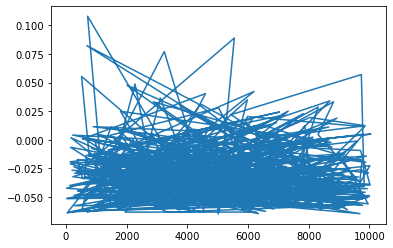

(array([1359.32137345]), array([3.69713456e-259]), array([1353.39299986]), array([6.59452613e-258]))
p-valeur du test de Ljung-Box: [3.69713456e-259]
p-valeur du test de Box-Pierce test: [6.59452613e-258]
Cela doit être plus grand que 0.05


D:\anaconda3\lib\site-packages\statsmodels\stats\diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


In [32]:
#Use Lifelines to calculate the variance scaled Schoenfeld residuals for all regression variables in one go:
scaled_schoenfeld_residuals = cph.compute_residuals(training_dataframe=data_train, kind='scaled_schoenfeld')
#print(scaled_schoenfeld_residuals)
Variables=['y_nais','BEN_SEX_COD','CHOC','Nb_jours_moyen']
for variable in Variables:
    print('Pour la variable ' + str(variable) + ':')
    #Let's plot the residuals for AGE against time:
    plt.plot(scaled_schoenfeld_residuals.index[:500], scaled_schoenfeld_residuals[variable][:500])
    plt.show()
    #Run the Ljung-Box test to test for auto-correlation in residuals up to lag 40
    result=diag.acorr_ljungbox(x=scaled_schoenfeld_residuals[variable], lags=[40], boxpierce=True, model_df=0, period=None, return_df=None)
    print(result)
    print('p-valeur du test de Ljung-Box: ' + str(result[1]))
    print('p-valeur du test de Box-Pierce test: ' + str(result[3]))
    print('Cela doit être plus grand que 0.05')

In [33]:
cph.check_assumptions(data_train, p_value_threshold=0.05, show_plots=False)

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 8040 total observations, 2737 right-censored observations>
         test_name = proportional_hazard_test

---
                     test_statistic      p  -log2(p)
BEN_SEX_COD    km              0.54   0.46      1.11
               rank            0.63   0.43      1.23
CHOC           km             25.08 <0.005     20.79
               rank           27.49 <0.005     22.59
Nb_jours_moyen km             34.57 <0.005     27.86
               rank           37.59 <0.005     30.10
y_nais         km             20.21 <0.005     17.14
               rank           21.57 <0.005     18.16



1. Variable 'y_nais' failed the non-proportional test: p-value is <5e-05.

   Advice 1: the functional form of the variable 'y_nais' might be incorrect. That is, there may be
non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'y_nais' using pd.cut, and then specify it in
`strata=['y_nais', ...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


2. Variable 'CHOC' failed the non-proportional test: p-value is <5e-05.

   Advice: with so few unique values (only 2), you can include `strata=['CHOC', ...]` in the call in
`.fit`. See documentation in link [E] below.

3. Variable 'Nb_jours_moyen' failed the non-proportional test: p-value is <5e-05.

   Advice 1: the functional form of the variable 'Nb_jours_

[]

In [34]:
print("Vraisemblance en % (on la veut la plus grande possible) pour le dataset de train")
print(100*np.exp(cph.score(data_train)))
print("Vraisemblance en % (on la veut la plus grande possible) pour le dataset de test")
print(100*np.exp(cph.score(data_test)))

Vraisemblance en % (on la veut la plus grande possible) pour le dataset de train
0.4130420711304674
Vraisemblance en % (on la veut la plus grande possible) pour le dataset de test
1.0883167242339655


### Test de base ( sans stratification, avec pénalisation, avec spline)

In [35]:
profil_patient=pd.read_csv("../data/profil_patient.csv")
profil_patient['CHOC']=profil_patient['CHOC'].astype(int)
profil_patient['y_nais']=2016-profil_patient['y_nais']
#Nb_jours_moyen=Nombre de jours hospitalisé / Nombre de séjours
#Moyenne empirique du nombre de jours hospitalisé
profil_patient['Nb_jours_moyen']=profil_patient['Nb_jours_sej']/profil_patient['Nb_hospit']

In [36]:
data_train, data_test = train_test_split(profil_patient[['y_nais','BEN_SEX_COD','CHOC','Nb_jours_moyen','Nb_survie','Mort']], 
                                                    test_size=0.2, 
                                                    random_state=33)
                                                    #stratify = spooky_df['author_encoded'].values

In [37]:
data_train.head()

,y_nais,BEN_SEX_COD,CHOC,Nb_jours_moyen,Nb_survie,Mort
907,54,1,0,8.454545,226,True
8286,67,1,0,1.000000,1509,False
1276,88,2,0,5.800000,354,True
5022,95,2,0,8.142857,763,True
401,53,1,1,9.818182,236,True


In [39]:
cph = CoxPHFitter(penalizer=0.5, l1_ratio=0.1)
cph.fit(data_train, duration_col='Nb_survie', event_col='Mort',formula="bs(y_nais, df=4, lower_bound=19 , upper_bound=110)")
cph.print_summary(model="spline_model")

model,lifelines.CoxPHFitter
duration col,'Nb_survie'
event col,'Mort'
penalizer,0.5
l1 ratio,0.1
baseline estimation,breslow
number of observations,8040
number of events observed,5303
partial log-likelihood,-44402.66
time fit was run,2023-03-06 10:56:05 UTC
model,spline_model


<AxesSubplot:xlabel='log(HR) (95% CI)'>

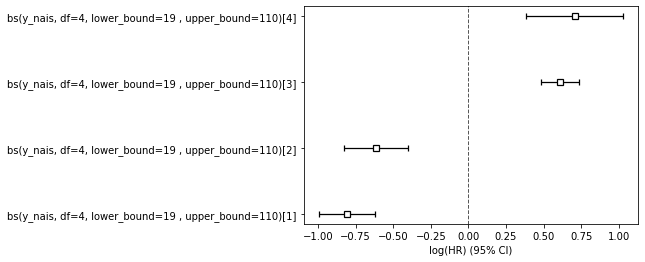

In [40]:
cph.plot()

In [42]:
#Use Lifelines to calculate the variance scaled Schoenfeld residuals for all regression variables in one go:
scaled_schoenfeld_residuals = cph.compute_residuals(training_dataframe=data_train, kind='scaled_schoenfeld')

Pour la variable bs(y_nais, df=4, lower_bound=19 , upper_bound=110)[1]:


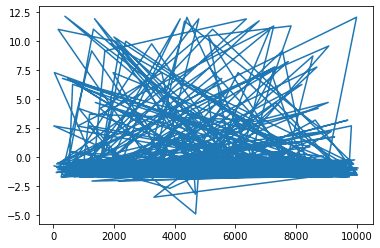

(array([85.9983289]), array([3.28970094e-05]), array([85.7026429]), array([3.58088746e-05]))
p-valeur du test de Ljung-Box: [3.28970094e-05]
p-valeur du test de Box-Pierce test: [3.58088746e-05]
Cela doit être plus grand que 0.05
Pour la variable bs(y_nais, df=4, lower_bound=19 , upper_bound=110)[2]:


D:\anaconda3\lib\site-packages\statsmodels\stats\diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


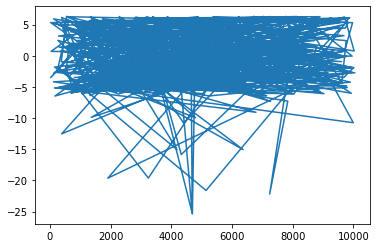

D:\anaconda3\lib\site-packages\statsmodels\stats\diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


(array([28.05570874]), array([0.92235148]), array([27.94229958]), array([0.92466759]))
p-valeur du test de Ljung-Box: [0.92235148]
p-valeur du test de Box-Pierce test: [0.92466759]
Cela doit être plus grand que 0.05
Pour la variable bs(y_nais, df=4, lower_bound=19 , upper_bound=110)[3]:


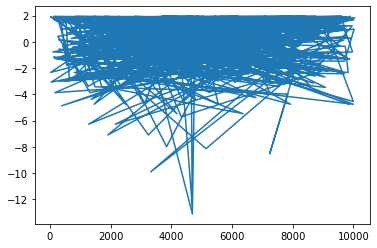

D:\anaconda3\lib\site-packages\statsmodels\stats\diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


(array([90.29238065]), array([9.3871157e-06]), array([89.91518976]), array([1.04973258e-05]))
p-valeur du test de Ljung-Box: [9.3871157e-06]
p-valeur du test de Box-Pierce test: [1.04973258e-05]
Cela doit être plus grand que 0.05
Pour la variable bs(y_nais, df=4, lower_bound=19 , upper_bound=110)[4]:


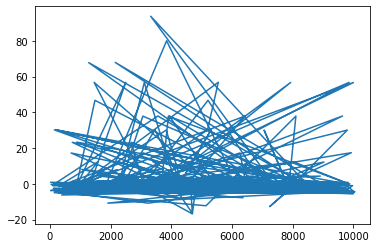

(array([37.26267033]), array([0.59416088]), array([37.10311873]), array([0.60139788]))
p-valeur du test de Ljung-Box: [0.59416088]
p-valeur du test de Box-Pierce test: [0.60139788]
Cela doit être plus grand que 0.05


D:\anaconda3\lib\site-packages\statsmodels\stats\diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


In [44]:
Variables=['bs(y_nais, df=4, lower_bound=19 , upper_bound=110)[1]','bs(y_nais, df=4, lower_bound=19 , upper_bound=110)[2]','bs(y_nais, df=4, lower_bound=19 , upper_bound=110)[3]','bs(y_nais, df=4, lower_bound=19 , upper_bound=110)[4]']
for variable in Variables:
    print('Pour la variable ' + str(variable) + ':')
    #Let's plot the residuals for AGE against time:
    plt.plot(scaled_schoenfeld_residuals.index[:500], scaled_schoenfeld_residuals[variable][:500])
    plt.show()
    #Run the Ljung-Box test to test for auto-correlation in residuals up to lag 40
    result=diag.acorr_ljungbox(x=scaled_schoenfeld_residuals[variable], lags=[40], boxpierce=True, model_df=0, period=None, return_df=None)
    print(result)
    print('p-valeur du test de Ljung-Box: ' + str(result[1]))
    print('p-valeur du test de Box-Pierce test: ' + str(result[3]))
    print('Cela doit être plus grand que 0.05')

In [45]:
cph.check_assumptions(data_train, p_value_threshold=0.05, show_plots=False)

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 8040 total observations, 2737 right-censored observations>
         test_name = proportional_hazard_test

---
                                                            test_statistic      p  -log2(p)
bs(y_nais, df=4, lower_bound=19 , upper_bound=110)[1] km             10.90 <0.005     10.02
                                                      rank           11.40 <0.005     10.41
bs(y_nais, df=4, lower_bound=19 , upper_bound=110)[2] km              0.51   0.47      1.08
                                                      rank            0.51   0.48      1.07
bs(y_nais, df=4, lower_bound=19 , upper_bound=110)[3] km             10.67 <0.005      9.84
                                                      rank           11.13 <0.005     10.20
bs(y_nais, df=4, lower_bound=19 , upper_bound=110)[4] km              0.56   0.46      1.13
                                                      rank            0.46   0.50      1.01



1. Variable 'bs(y_nais, df=4, lower_bound=19 , upper_bound=110)[1]' failed the non-proportional test: p-value is 0.0007.

   Advice 1: the functional form of the variable 'bs(y_nais, df=4, lower_bound=19 ,
upper_bound=110)[1]' might be incorrect. That is, there may be non-linear terms missing. The
proportional hazard test used is very sensitive to incorrect functional forms. See documentation in
link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'bs(y_nais, df=4, lower_bound=19 , upper_bound=110)[1]' using
pd.cut, and then specify it in `strata=['bs(y_nais, df=4, lower_bound=19 , upper_bound=110)[1]',
...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


2. Variable 'bs(y_nais, df=4, lower_bound=19 , upper_bound=110)[3]' failed the non-proportional test: p-value is 0.0008.

   Advice 1: the functional form of the variable 'bs

[]

In [46]:
print("Vraisemblance en % (on la veut la plus grande possible) pour le dataset de train")
print(100*np.exp(cph.score(data_train)))
print("Vraisemblance en % (on la veut la plus grande possible) pour le dataset de test")
print(100*np.exp(cph.score(data_test)))

Vraisemblance en % (on la veut la plus grande possible) pour le dataset de train
0.40992013879854444
Vraisemblance en % (on la veut la plus grande possible) pour le dataset de test
1.0738249860998927


### Test de base ( avec stratification, avec pénalisation, sans spline)

In [48]:
data_train, data_test = train_test_split(profil_patient[['BEN_SEX_COD','CHOC','cluster','Nb_survie','Mort']], 
                                                    test_size=0.2, 
                                                    random_state=33,
                                                    stratify = profil_patient['cluster'].values)

In [49]:
cph = CoxPHFitter(penalizer=0.01,l1_ratio=0.1)
cph.fit(data_train, duration_col='Nb_survie', event_col='Mort',strata='cluster')
cph.print_summary()

model,lifelines.CoxPHFitter
duration col,'Nb_survie'
event col,'Mort'
penalizer,0.01
l1 ratio,0.1
strata,cluster
baseline estimation,breslow
number of observations,8040
number of events observed,5315
partial log-likelihood,-33031.59
time fit was run,2023-03-06 10:59:37 UTC


<AxesSubplot:xlabel='log(HR) (95% CI)'>

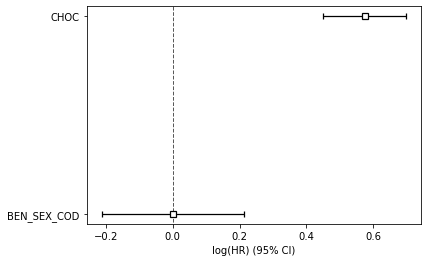

In [50]:
cph.plot()

Text(0, 0.5, 'Probabilité de survie')

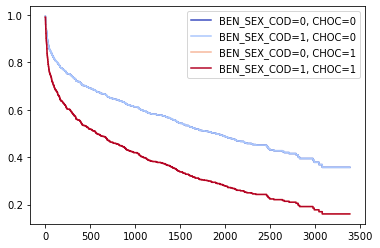

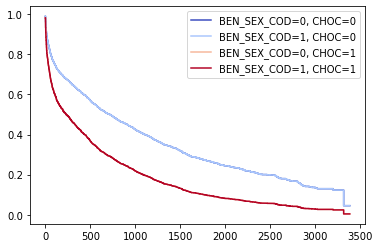

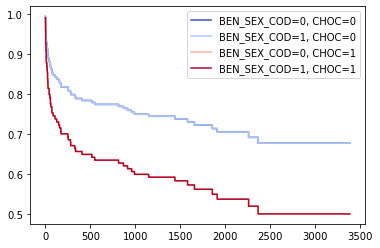

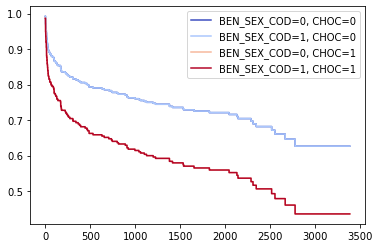

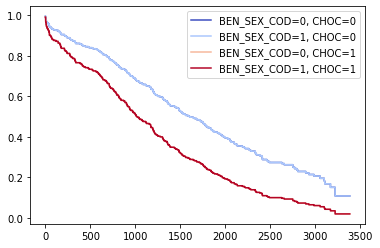

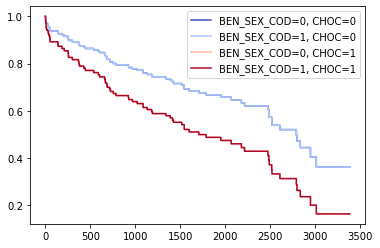

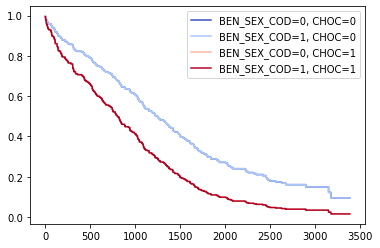

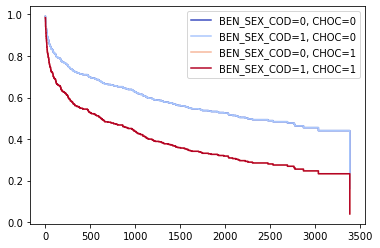

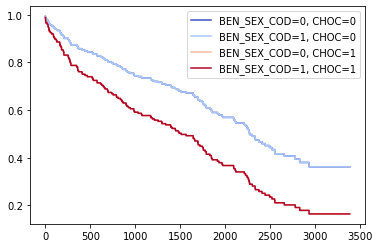

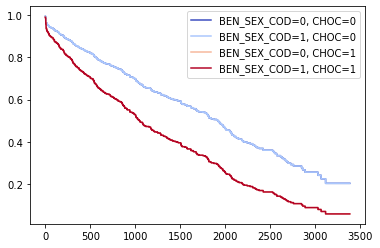

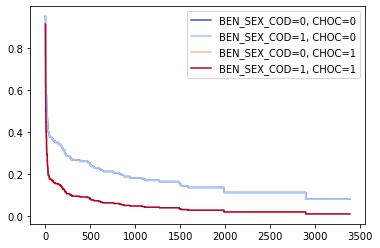

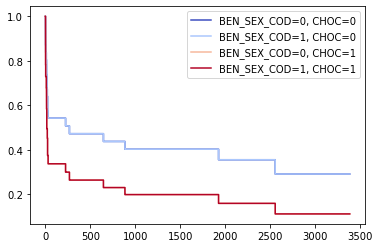

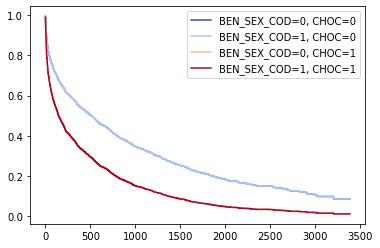

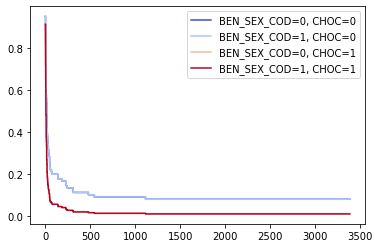

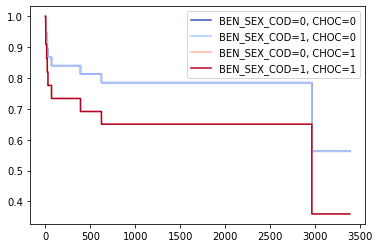

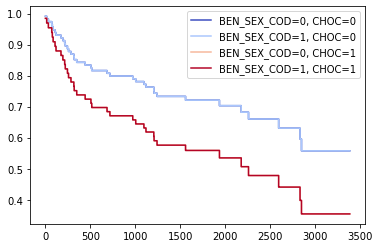

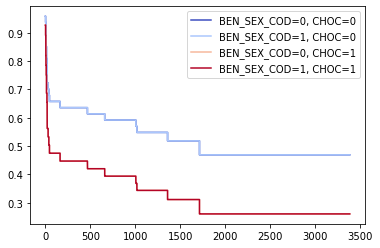

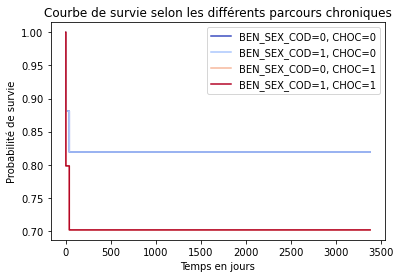

In [51]:
cph.plot_partial_effects_on_outcome(covariates=['BEN_SEX_COD','CHOC'], values=[(0,0),(1,0),(0,1),(1,1)], cmap='coolwarm', plot_baseline=False)
plt.title("Courbe de survie selon les différents parcours chroniques")
plt.xlabel("Temps en jours")
plt.ylabel("Probabilité de survie")

Pour la variable BEN_SEX_COD:


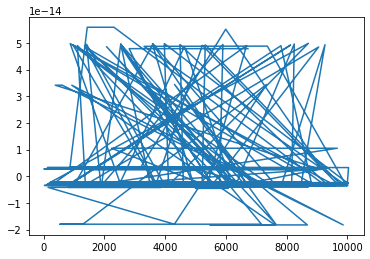

(array([12944.01338498]), array([0.]), array([12915.5643059]), array([0.]))
p-valeur du test de Ljung-Box: [0.]
p-valeur du test de Box-Pierce test: [0.]
Cela doit être plus grand que 0.05
Pour la variable CHOC:


D:\anaconda3\lib\site-packages\statsmodels\stats\diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


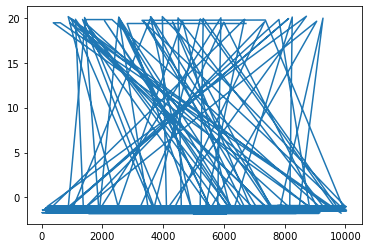

(array([137.04006423]), array([1.49769076e-12]), array([136.65579795]), array([1.72241986e-12]))
p-valeur du test de Ljung-Box: [1.49769076e-12]
p-valeur du test de Box-Pierce test: [1.72241986e-12]
Cela doit être plus grand que 0.05


D:\anaconda3\lib\site-packages\statsmodels\stats\diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


In [52]:
#Use Lifelines to calculate the variance scaled Schoenfeld residuals for all regression variables in one go:
scaled_schoenfeld_residuals = cph.compute_residuals(training_dataframe=data_train, kind='scaled_schoenfeld')
Variables=['BEN_SEX_COD','CHOC']
for variable in Variables:
    print('Pour la variable ' + str(variable) + ':')
    #Let's plot the residuals for AGE against time:
    plt.plot(scaled_schoenfeld_residuals.index[:500], scaled_schoenfeld_residuals[variable][:500])
    plt.show()
    #Run the Ljung-Box test to test for auto-correlation in residuals up to lag 40
    result=diag.acorr_ljungbox(x=scaled_schoenfeld_residuals[variable], lags=[40], boxpierce=True, model_df=0, period=None, return_df=None)
    print(result)
    print('p-valeur du test de Ljung-Box: ' + str(result[1]))
    print('p-valeur du test de Box-Pierce test: ' + str(result[3]))
    print('Cela doit être plus grand que 0.05')

In [53]:
cph.check_assumptions(data_train, p_value_threshold=0.05, show_plots=False)

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 8040 total observations, 2725 right-censored observations>
         test_name = proportional_hazard_test

---
                  test_statistic      p  -log2(p)
BEN_SEX_COD km              0.00   1.00      0.00
            rank            0.00   1.00      0.00
CHOC        km             64.12 <0.005     49.60
            rank           12.01 <0.005     10.88



1. Variable 'CHOC' failed the non-proportional test: p-value is <5e-05.

   Advice: with so few unique values (only 2), you can include `strata=['CHOC', ...]` in the call in
`.fit`. See documentation in link [E] below.

---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-and-stratify-on-it
[C]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Introduce-time-varying-covariates
[D]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Modify-the-functional-form
[E]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Stratification



[]

In [54]:
print("Vraisemblance en % (on la veut la plus grande possible) pour le dataset de train")
print(100*np.exp(cph.score(data_train)))
print("Vraisemblance en % (on la veut la plus grande possible) pour le dataset de test")
print(100*np.exp(cph.score(data_test)))

Vraisemblance en % (on la veut la plus grande possible) pour le dataset de train
1.6437355383754984
Vraisemblance en % (on la veut la plus grande possible) pour le dataset de test
4.318987548095622


### Ancien test

In [2]:
profil_patient=pd.read_csv("../data/profil_patient.csv")
profil_patient['CHOC']=profil_patient['CHOC'].astype(int)

In [3]:
profil_patient

,CODE_PATIENT,date_h0,y_nais,BEN_RES_DPT,BEN_SEX_COD,dte_deces,Mort,Nb_survie,Nb_hospit,CHOC,Nb_jours_sej,cat_age,cat_nb_hospit,cat_nb_jours_sej,cluster
0,P0,2011-11-22,1949,11,1,NaN,False,2596,9,0,23,1,1,1,0
1,P6,2013-12-05,1929,14,2,2015-03,True,456,8,0,51,2,1,1,1
2,P8,2015-07-02,1967,54,2,2015-08,True,41,3,1,43,0,1,1,2
3,P13,2011-05-19,1959,974,1,NaN,False,2783,2,0,3,0,1,0,3
4,P16,2010-03-18,1947,76,1,NaN,False,3210,9,0,28,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10046,P24302,2014-02-08,1920,29,1,2014-12,True,318,8,0,47,2,1,1,12
10047,P24303,2012-02-09,1927,61,1,2017-05,True,1924,12,0,86,2,2,2,6
10048,P24304,2010-07-27,1924,999,1,2010-08,True,5,1,0,10,2,0,1,13
10049,P24308,2011-11-25,1925,13,2,2013-03,True,484,7,0,99,2,1,2,1


In [4]:
data=profil_patient[['Nb_survie','Mort','CHOC','cluster','BEN_SEX_COD']]
data_train=data.loc[:0.8*data['Nb_survie'].size]
data_test=data.loc[0.8*data['Nb_survie'].size:]

In [145]:
cph = CoxPHFitter(penalizer=0.9)
cph.fit(data_train, duration_col='Nb_survie', event_col='Mort', strata='CHOC')
cph.print_summary(model="spline_model")

model,lifelines.CoxPHFitter
duration col,'Nb_survie'
event col,'Mort'
penalizer,0.9
l1 ratio,0.0
strata,CHOC
baseline estimation,breslow
number of observations,8041
number of events observed,5303
partial log-likelihood,-43545.69
time fit was run,2023-02-08 10:08:10 UTC


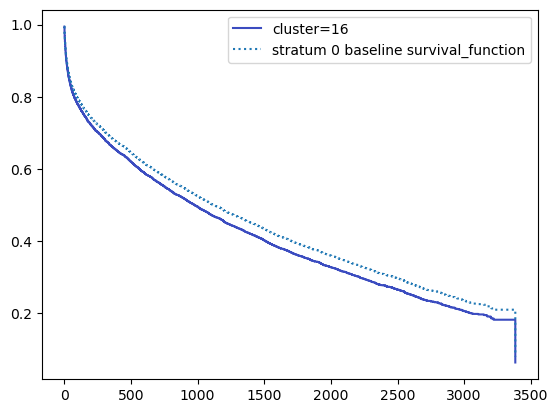

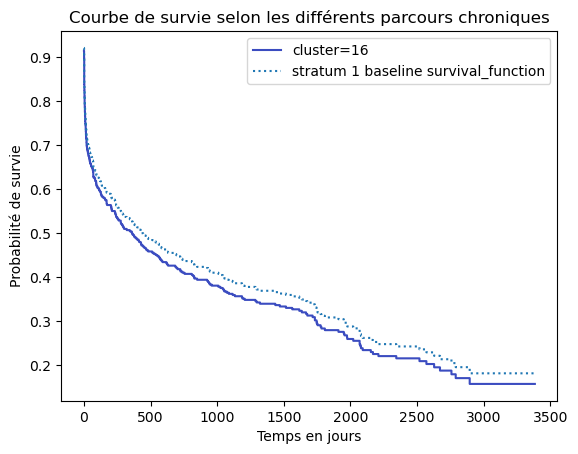

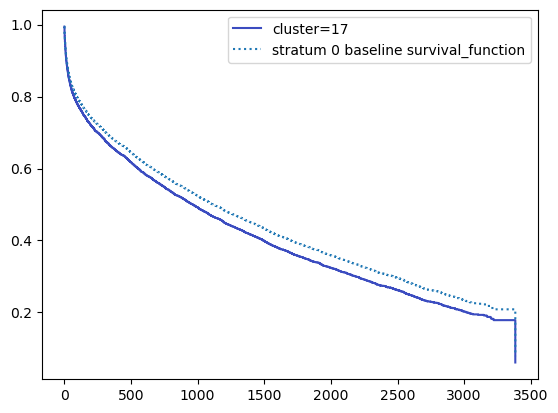

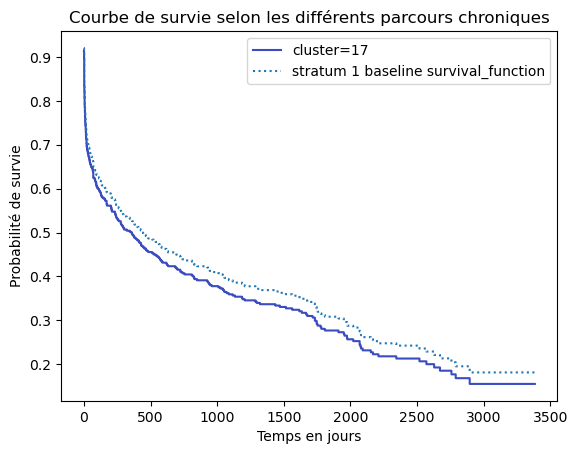

In [266]:
for i in range(16,18): 
        cph.plot_partial_effects_on_outcome(covariates=['cluster'], values=[i], cmap='coolwarm')
        plt.title("Courbe de survie selon les différents parcours chroniques")
        plt.xlabel("Temps en jours")
        plt.ylabel("Probabilité de survie")

<AxesSubplot: xlabel='log(HR) (95% CI)'>

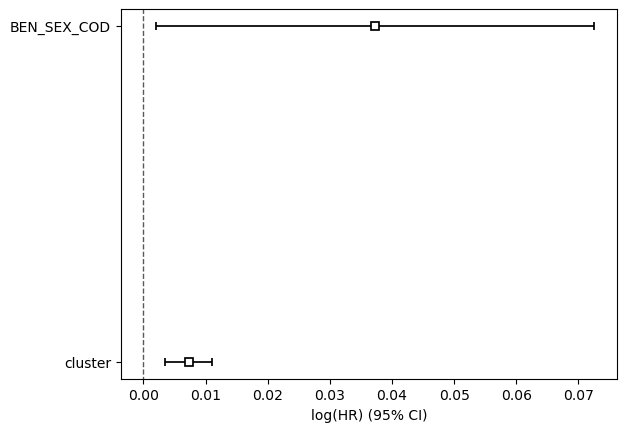

In [267]:
cph.plot()

In [91]:
cph.params_

covariate
cluster        0.007425
BEN_SEX_COD    0.037362
Name: coef, dtype: float64

Pour la variable cluster:


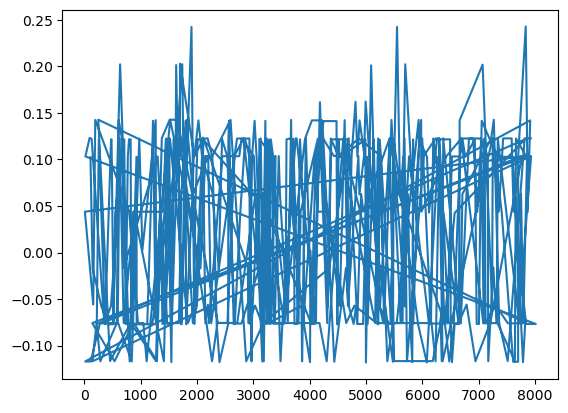

(array([43.20119264]), array([0.33617698]), array([43.03468568]), array([0.3426528]))
p-valeur du test de Ljung-Box: [0.33617698]
p-valeur du test de Box-Pierce test: [0.33617698]
Cela doit être plus grand que 0.05
Pour la variable BEN_SEX_COD:


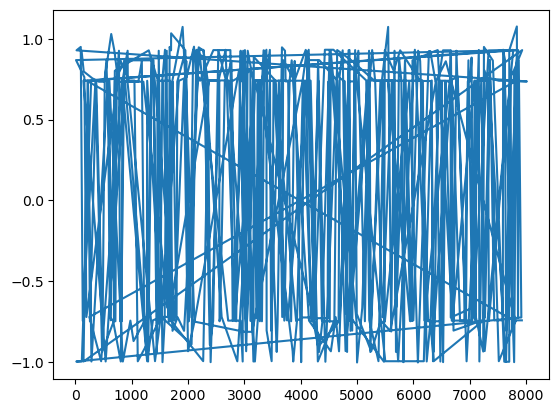

(array([47.56889989]), array([0.19171761]), array([47.37520106]), array([0.1970305]))
p-valeur du test de Ljung-Box: [0.19171761]
p-valeur du test de Box-Pierce test: [0.19171761]
Cela doit être plus grand que 0.05


In [268]:
#Use Lifelines to calculate the variance scaled Schoenfeld residuals for all regression variables in one go:
scaled_schoenfeld_residuals = cph.compute_residuals(training_dataframe=data_train, kind='scaled_schoenfeld')
#print(scaled_schoenfeld_residuals)
import statsmodels.stats.diagnostic as diag
Variables=['cluster','BEN_SEX_COD']
for variable in Variables:
    print('Pour la variable ' + str(variable) + ':')
    #Let's plot the residuals for AGE against time:
    plt.plot(scaled_schoenfeld_residuals.index[:500], scaled_schoenfeld_residuals[variable][:500])
    plt.show()
    #Run the Ljung-Box test to test for auto-correlation in residuals up to lag 40
    result=diag.acorr_ljungbox(x=scaled_schoenfeld_residuals[variable], lags=[40], boxpierce=True, model_df=0, period=None, return_df=None)
    print(result)
    print('p-valeur du test de Ljung-Box: ' + str(result[1]))
    print('p-valeur du test de Box-Pierce test: ' + str(result[1]))
    print('Cela doit être plus grand que 0.05')

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 8041 total observations, 2738 right-censored observations>
         test_name = proportional_hazard_test

---
                  test_statistic      p  -log2(p)
BEN_SEX_COD km              0.20   0.66      0.61
            rank            0.58   0.45      1.17
cluster     km              3.63   0.06      4.14
            rank           13.27 <0.005     11.86



1. Variable 'cluster' failed the non-proportional test: p-value is 0.0003.

   Advice 1: the functional form of the variable 'cluster' might be incorrect. That is, there may be
non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'cluster' using pd.cut, and then specify it in
`strata=['cluster', ...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


   Bootstrapping lowess lines. May take a moment...


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-and-stratify-on-it
[C]  https://lifelines.readthedocs.io/en/latest/jupyter_

[[<AxesSubplot: xlabel='rank-transformed time\n(p=0.0003)'>,
  <AxesSubplot: xlabel='km-transformed time\n(p=0.0569)'>]]

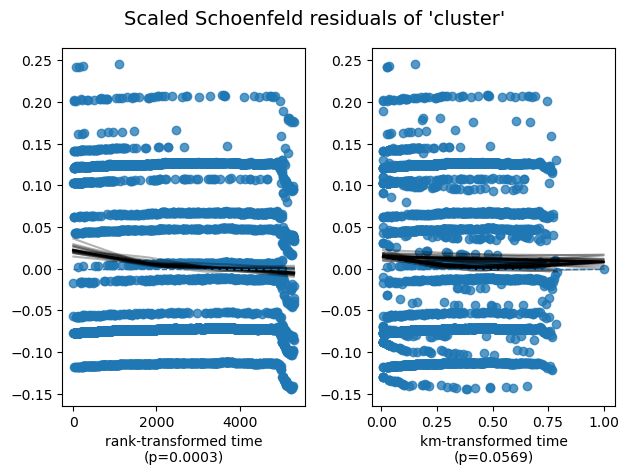

In [269]:
cph.check_assumptions(data_train, p_value_threshold=0.05, show_plots=True)

In [188]:
print("Vraisemblance en % (on la veut la plus grande possible) pour le dataset de train")
print(100*np.exp(cph.score(data_train)))
print("Vraisemblance en % (on la veut la plus grande possible) pour le dataset de test")
print(100*np.exp(cph.score(data_test)))

Vraisemblance en % (on la veut la plus grande possible) pour le dataset de train
0.4452200005258185
Vraisemblance en % (on la veut la plus grande possible) pour le dataset de test
1.122790129399941


## Test avec des modèles paramétriques

### Weibull

In [5]:
from lifelines import WeibullAFTFitter

In [8]:
data_train['Nb_survie']+=0.01

/tmp/ipykernel_251/3800373657.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train['Nb_survie']+=0.01


In [34]:
aft = WeibullAFTFitter(penalizer=0.1)
aft.fit(data_train, duration_col='Nb_survie', event_col='Mort',ancillary=True)

aft.print_summary(3)  # access the results using aft.summary

<lifelines.WeibullAFTFitter: fitted with 8041 total observations, 2738 right-censored observations>
             duration col = 'Nb_survie'
                event col = 'Mort'
                penalizer = 0.1
   number of observations = 8041
number of events observed = 5303
           log-likelihood = -42979.702
         time fit was run = 2023-02-08 09:32:56 UTC

---
                      coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param   covariate                                                                                                           
lambda_ BEN_SEX_COD -0.120      0.887      0.041           -0.201           -0.039                0.818                0.962
        CHOC        -0.450      0.638      0.096           -0.638           -0.262                0.528                0.769
        cluster     -0.023      0.977      0.004           -0.032           -0.014                0.969                0.986
        Intercept    7.847   2558.593      0.076            7.699            7.996             2205.807             2967.801
rho_    Intercept   -0.595      0.551      0.011           -0.617           -0.573                0.540                0.564

                      cmp to       z       p   -log2(p)
param   covariate                                      
lambda_ BEN_SEX_COD    0.000  -2.900   0.004      8.067
        CHOC           0.000  -4.699 <0.0005     18.542
        cluster        0.000  -5.083 <0.0005     21.362
        Intercept      0.000 103.666 <0.0005        inf
rho_    Intercept      0.000 -53.134 <0.0005        inf
---
Concordance = 0.544
AIC = 85969.405
log-likelihood ratio test = -268.987 on 3 df
-log2(p) of ll-ratio test = -0.000

<AxesSubplot: xlabel='log(accelerated failure rate) (95% CI)'>

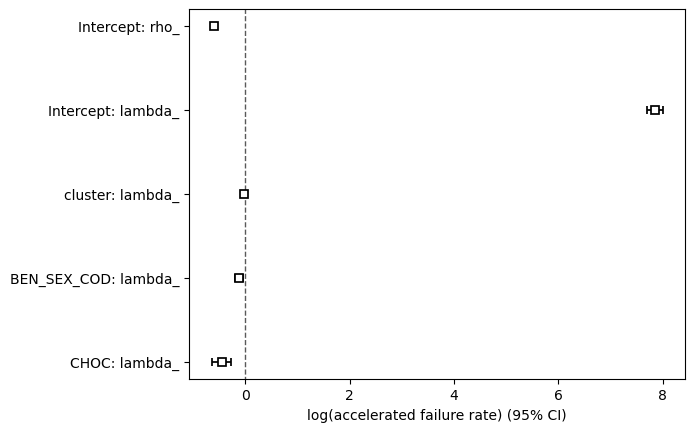

In [35]:
aft.plot()

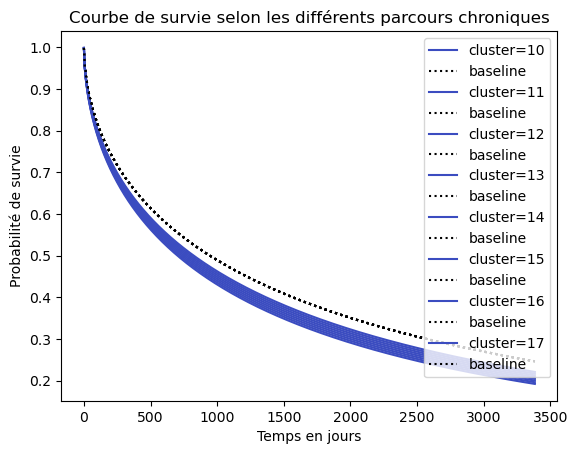

In [36]:
for i in range(10,18): 
        aft.plot_partial_effects_on_outcome(covariates=['cluster'], values=[i], cmap='coolwarm')
        plt.title("Courbe de survie selon les différents parcours chroniques")
        plt.xlabel("Temps en jours")
        plt.ylabel("Probabilité de survie")

In [166]:
print("Vraisemblance en % (on la veut la plus grande possible) pour le dataset de train")
print(100*np.exp(aft.score(data_train)))
print("Vraisemblance en % (on la veut la plus grande possible) pour le dataset de test")
print(100*np.exp(aft.score(data_test)))

Vraisemblance en % (on la veut la plus grande possible) pour le dataset de train
0.48605575803361095
Vraisemblance en % (on la veut la plus grande possible) pour le dataset de test
0.49177656913099155


In [134]:
aft.log_likelihood_ratio_test()

<lifelines.StatisticalResult: log-likelihood ratio test>
  degrees_freedom = 3
null_distribution = chi squared
        test_name = log-likelihood ratio test

---
 test_statistic    p  -log2(p)
        -268.99 1.00     -0.00

In [38]:
from lifelines import LogLogisticAFTFitter
from lifelines import LogNormalAFTFitter

### Log-logistic

In [79]:
llf = LogLogisticAFTFitter(penalizer=0.1).fit(data_train, duration_col='Nb_survie', event_col='Mort',ancillary=data_train)
llf.print_summary(3)  # access the results using aft.summary

<lifelines.LogLogisticAFTFitter: fitted with 8041 total observations, 2738 right-censored observations>
             duration col = 'Nb_survie'
                event col = 'Mort'
                penalizer = 0.1
   number of observations = 8041
number of events observed = 5303
           log-likelihood = -42931.046
         time fit was run = 2023-02-08 09:45:02 UTC

---
                     coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param  covariate                                                                                                           
alpha_ BEN_SEX_COD -0.176      0.839      0.048           -0.271           -0.081                0.763                0.922
       CHOC        -0.480      0.619      0.139           -0.752           -0.208                0.471                0.812
       cluster     -0.029      0.972      0.005           -0.039           -0.018                0.962                0.982
       Intercept    7.262   1425.448      0.087            7.091            7.433             1201.427             1691.242
beta_  BEN_SEX_COD -0.093      0.912      0.024           -0.140           -0.045                0.869                0.956
       CHOC        -0.506      0.603      0.050           -0.604           -0.407                0.547                0.665
       cluster     -0.012      0.988      0.002           -0.016           -0.007                0.984                0.993
       Intercept   -0.243      0.785      0.045           -0.331           -0.154                0.718                0.857

                     cmp to       z       p   -log2(p)
param  covariate                                      
alpha_ BEN_SEX_COD    0.000  -3.642 <0.0005     11.849
       CHOC           0.000  -3.457   0.001     10.838
       cluster        0.000  -5.458 <0.0005     24.305
       Intercept      0.000  83.250 <0.0005        inf
beta_  BEN_SEX_COD    0.000  -3.822 <0.0005     12.883
       CHOC           0.000 -10.092 <0.0005     77.137
       cluster        0.000  -4.751 <0.0005     18.915
       Intercept      0.000  -5.375 <0.0005     23.638
---
Concordance = 0.543
AIC = 85878.092
log-likelihood ratio test = 201.854 on 6 df
-log2(p) of ll-ratio test = 133.264

<AxesSubplot: xlabel='log(accelerated failure rate) (95% CI)'>

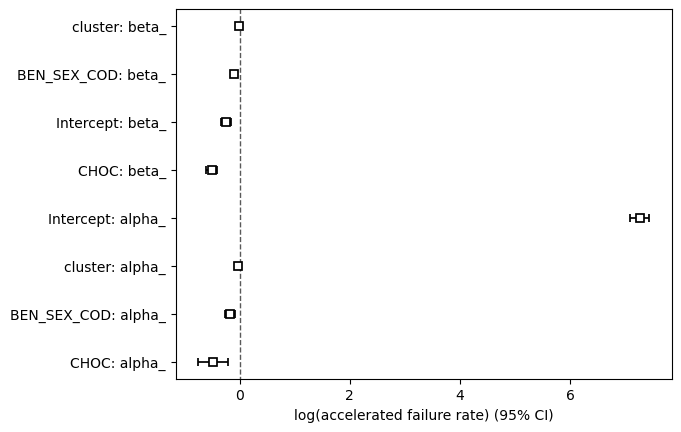

In [80]:
llf.plot()

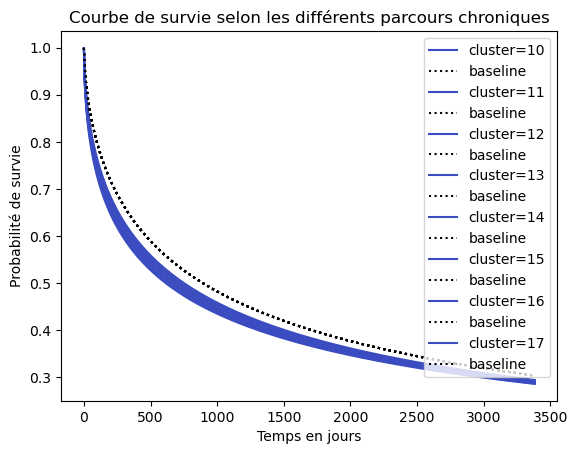

In [81]:
for i in range(10,18): 
        llf.plot_partial_effects_on_outcome(covariates=['cluster'], values=[i], cmap='coolwarm')
        plt.title("Courbe de survie selon les différents parcours chroniques")
        plt.xlabel("Temps en jours")
        plt.ylabel("Probabilité de survie")

In [167]:
print("Vraisemblance en % (on la veut la plus grande possible) pour le dataset de train")
print(100*np.exp(llf.score(data_train)))
print("Vraisemblance en % (on la veut la plus grande possible) pour le dataset de test")
print(100*np.exp(llf.score(data_test)))

Vraisemblance en % (on la veut la plus grande possible) pour le dataset de train
0.48133149504458866
Vraisemblance en % (on la veut la plus grande possible) pour le dataset de test
0.48535118762892127


In [168]:
llf.log_likelihood_ratio_test()

<lifelines.StatisticalResult: log-likelihood ratio test>
  degrees_freedom = 6
null_distribution = chi squared
        test_name = log-likelihood ratio test

---
 test_statistic      p  -log2(p)
         201.85 <0.005    133.26

### Log-normal

In [104]:
lnf = LogNormalAFTFitter(penalizer=0.1).fit(data_train, duration_col='Nb_survie', event_col='Mort',ancillary=True)
lnf.print_summary(3)  # access the results using aft.summary

<lifelines.LogNormalAFTFitter: fitted with 8041 total observations, 2738 right-censored observations>
             duration col = 'Nb_survie'
                event col = 'Mort'
                penalizer = 0.1
   number of observations = 8041
number of events observed = 5303
           log-likelihood = -43057.321
         time fit was run = 2023-02-08 09:49:23 UTC

---
                     coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param  covariate                                                                                                           
mu_    BEN_SEX_COD -0.169      0.845      0.051           -0.268           -0.070                0.765                0.933
       CHOC        -0.455      0.634      0.145           -0.739           -0.171                0.478                0.843
       cluster     -0.028      0.972      0.006           -0.039           -0.017                0.962                0.983
       Intercept    7.174   1305.255      0.091            6.996            7.352             1092.746             1559.091
sigma_ BEN_SEX_COD  0.096      1.101      0.021            0.055            0.137                1.057                1.146
       CHOC         0.515      1.674      0.043            0.431            0.600                1.539                1.822
       cluster      0.011      1.011      0.002            0.007            0.015                1.007                1.015
       Intercept    0.840      2.317      0.039            0.765            0.916                2.148                2.499

                     cmp to      z       p   -log2(p)
param  covariate                                     
mu_    BEN_SEX_COD    0.000 -3.333   0.001     10.185
       CHOC           0.000 -3.141   0.002      9.212
       cluster        0.000 -5.078 <0.0005     21.323
       Intercept      0.000 79.126 <0.0005        inf
sigma_ BEN_SEX_COD    0.000  4.601 <0.0005     17.859
       CHOC           0.000 11.966 <0.0005    107.211
       cluster        0.000  5.233 <0.0005     22.514
       Intercept      0.000 21.784 <0.0005    347.088
---
Concordance = 0.543
AIC = 86130.643
log-likelihood ratio test = 302.740 on 6 df
-log2(p) of ll-ratio test = 204.878

<AxesSubplot: xlabel='log(accelerated failure rate) (95% CI)'>

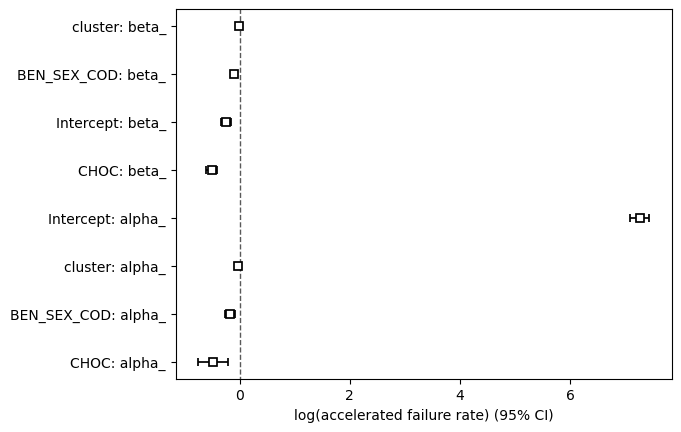

In [105]:
llf.plot()

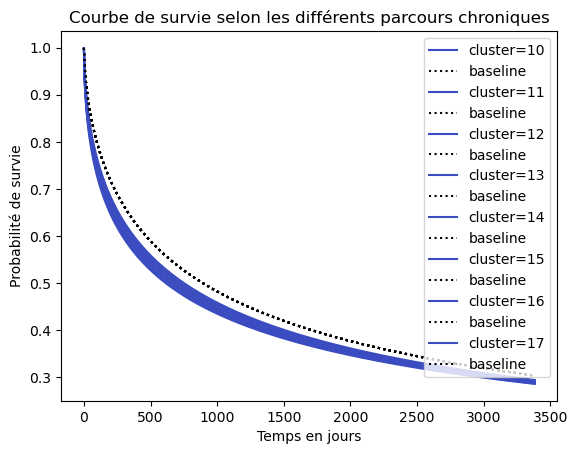

In [106]:
for i in range(10,18): 
        llf.plot_partial_effects_on_outcome(covariates=['cluster'], values=[i], cmap='coolwarm')
        plt.title("Courbe de survie selon les différents parcours chroniques")
        plt.xlabel("Temps en jours")
        plt.ylabel("Probabilité de survie")

In [169]:
print("Vraisemblance en % (on la veut la plus grande possible) pour le dataset de train")
print(100*np.exp(lnf.score(data_train)))
print("Vraisemblance en % (on la veut la plus grande possible) pour le dataset de test")
print(100*np.exp(lnf.score(data_test)))

Vraisemblance en % (on la veut la plus grande possible) pour le dataset de train
0.47377692432112567
Vraisemblance en % (on la veut la plus grande possible) pour le dataset de test
0.47672895526315645


In [136]:
llf.log_likelihood_ratio_test()

<lifelines.StatisticalResult: log-likelihood ratio test>
  degrees_freedom = 6
null_distribution = chi squared
        test_name = log-likelihood ratio test

---
 test_statistic      p  -log2(p)
         201.85 <0.005    133.26

### Gamma

In [108]:
from lifelines import GeneralizedGammaRegressionFitter

In [197]:
ggf = GeneralizedGammaRegressionFitter(penalizer=0).fit(data_train, duration_col='Nb_survie', event_col='Mort')
ggf.print_summary(3)  # access the results using aft.summary

<lifelines.GeneralizedGammaRegressionFitter: fitted with 8041 total observations, 2738 right-censored observations>
             duration col = 'Nb_survie'
                event col = 'Mort'
   number of observations = 8041
number of events observed = 5303
           log-likelihood = -44777.199
         time fit was run = 2023-02-08 10:37:14 UTC

---
                      coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param   covariate                                                                                                           
sigma_  CHOC         0.256      1.292      0.249           -0.232            0.744                0.793                2.104
        cluster     -0.016      0.984      0.008           -0.032            0.000                0.968                1.000
        BEN_SEX_COD  0.884      2.420      0.033            0.819            0.949                2.267                2.583
mu_     CHOC         0.024      1.025      0.396           -0.751            0.800                0.472                2.226
        cluster      0.196      1.217      0.011            0.176            0.217                1.192                1.243
        BEN_SEX_COD  4.850    127.709      0.081            4.690            5.009              108.858              149.824
lambda_ CHOC         0.490      1.632      0.094            0.306            0.674                1.357                1.962
        cluster      0.094      1.099      0.004            0.087            0.101                1.091                1.107
        BEN_SEX_COD -0.147      0.863      0.010           -0.168           -0.127                0.846                0.881

                      cmp to       z       p   -log2(p)
param   covariate                                      
sigma_  CHOC           0.000   1.028   0.304      1.719
        cluster        0.000  -1.949   0.051      4.284
        BEN_SEX_COD    0.000  26.566 <0.0005    514.138
mu_     CHOC           0.000   0.062   0.951      0.073
        cluster        0.000  18.644 <0.0005    255.293
        BEN_SEX_COD    0.000  59.517 <0.0005        inf
lambda_ CHOC           0.000   5.210 <0.0005     22.339
        cluster        0.000  24.970 <0.0005    454.723
        BEN_SEX_COD    0.000 -14.018 <0.0005    145.892
---
AIC = 89572.398
log-likelihood ratio test = -4049.423 on 6 df
-log2(p) of ll-ratio test = -0.000

<AxesSubplot: xlabel='coef (95% CI)'>

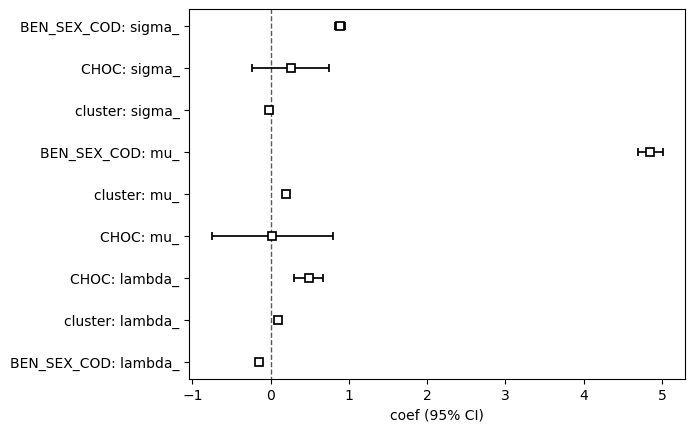

In [198]:
ggf.plot()

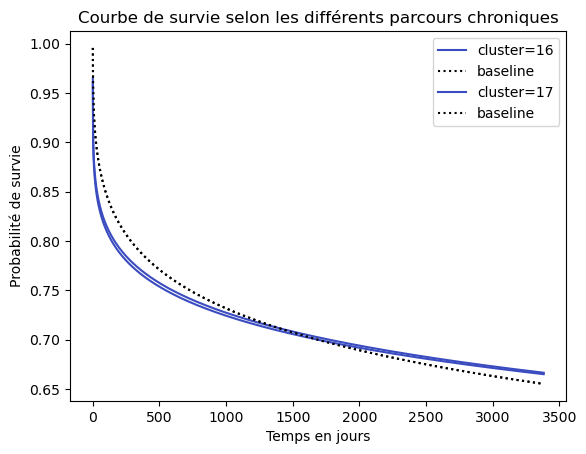

In [200]:
for i in range(16,18): 
        ggf.plot_partial_effects_on_outcome(covariates=['cluster'], values=[i], cmap='coolwarm')
        plt.title("Courbe de survie selon les différents parcours chroniques")
        plt.xlabel("Temps en jours")
        plt.ylabel("Probabilité de survie")

In [170]:
print("Vraisemblance en % (on la veut la plus grande possible) pour le dataset de train")
print(100*np.exp(ggf.score(data_train)))
print("Vraisemblance en % (on la veut la plus grande possible) pour le dataset de test")
print(100*np.exp(ggf.score(data_test)))

Vraisemblance en % (on la veut la plus grande possible) pour le dataset de train
0.0
Vraisemblance en % (on la veut la plus grande possible) pour le dataset de test
0.0


In [130]:
ggf.log_likelihood_ratio_test()

<lifelines.StatisticalResult: log-likelihood ratio test>
  degrees_freedom = 6
null_distribution = chi squared
        test_name = log-likelihood ratio test

---
 test_statistic    p  -log2(p)
      -12420.36 1.00     -0.00

<lifelines.WeibullFitter:"Weibull_estimate", fitted with 8041 total observations, 2738 right-censored observations>


<AxesSubplot: >

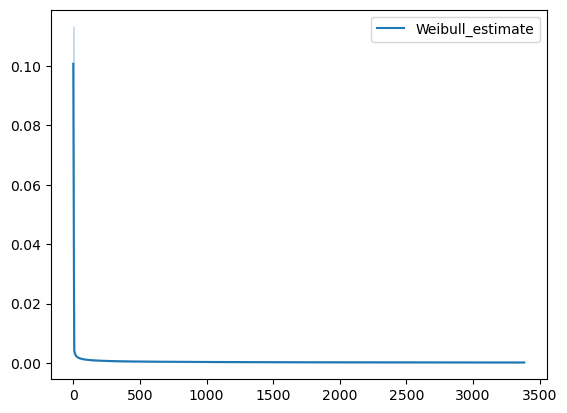

In [171]:
from lifelines.utils import find_best_parametric_model
from lifelines.datasets import load_lymph_node


best_model, best_aic_ = find_best_parametric_model(data_train['Nb_survie'], data_train['Mort'], scoring_method="AIC")

print(best_model)
# <lifelines.SplineFitter:"Spline_estimate", fitted with 686 total observations, 387 right-censored observations>

best_model.plot_hazard()

<AxesSubplot: >

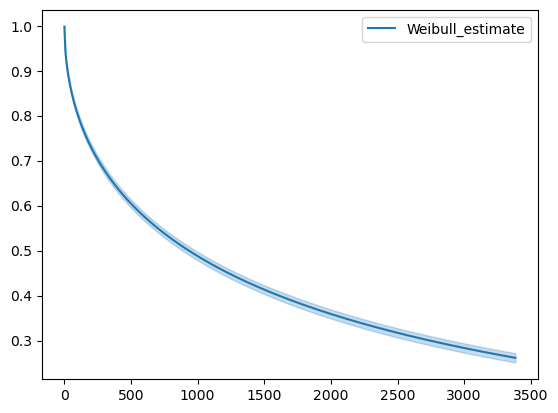

In [172]:
best_model.plot_survival_function()

In [163]:
data_test['Nb_survie']+=0.01

/tmp/ipykernel_251/1119681757.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['Nb_survie']+=0.01


In [190]:
from lifelines import AalenAdditiveFitter, CoxPHFitter
from lifelines.utils import k_fold_cross_validation



print(100*np.exp(np.mean(k_fold_cross_validation(cph, data_test, duration_col='Nb_survie', event_col='Mort', scoring_method="concordance_index",k=5))))
print(100*np.exp(np.mean(k_fold_cross_validation(aft, data_test, duration_col='Nb_survie', event_col='Mort', scoring_method="concordance_index",k=5))))
print(100*np.exp(np.mean(k_fold_cross_validation(llf, data_test, duration_col='Nb_survie', event_col='Mort', scoring_method="concordance_index",k=5))))
print(100*np.exp(np.mean(k_fold_cross_validation(lnf, data_test, duration_col='Nb_survie', event_col='Mort', scoring_method="concordance_index",k=5))))

/opt/mamba/lib/python3.10/site-packages/lifelines/utils/__init__.py:935: UserWarning: DataFrame Index is not unique, defaulting to incrementing index instead.
  warnings.warn("DataFrame Index is not unique, defaulting to incrementing index instead.")
/opt/mamba/lib/python3.10/site-packages/lifelines/utils/__init__.py:935: UserWarning: DataFrame Index is not unique, defaulting to incrementing index instead.
  warnings.warn("DataFrame Index is not unique, defaulting to incrementing index instead.")
/opt/mamba/lib/python3.10/site-packages/lifelines/utils/__init__.py:935: UserWarning: DataFrame Index is not unique, defaulting to incrementing index instead.
  warnings.warn("DataFrame Index is not unique, defaulting to incrementing index instead.")
/opt/mamba/lib/python3.10/site-packages/lifelines/utils/__init__.py:935: UserWarning: DataFrame Index is not unique, defaulting to incrementing index instead.
  warnings.warn("DataFrame Index is not unique, defaulting to incrementing index instead

172.11478779039473
172.90508697806294
172.40191072078417
172.3184764879586


In [191]:
print(100*np.exp(np.mean(k_fold_cross_validation(cph, data_test, duration_col='Nb_survie', event_col='Mort', scoring_method="log_likelihood",k=5))))
print(100*np.exp(np.mean(k_fold_cross_validation(aft, data_test, duration_col='Nb_survie', event_col='Mort', scoring_method="log_likelihood",k=5))))
print(100*np.exp(np.mean(k_fold_cross_validation(llf, data_test, duration_col='Nb_survie', event_col='Mort', scoring_method="log_likelihood",k=5))))
print(100*np.exp(np.mean(k_fold_cross_validation(lnf, data_test, duration_col='Nb_survie', event_col='Mort', scoring_method="log_likelihood",k=5))))

3.2046479083968307
0.4904745366085394
0.4838526230962762
0.47327760056646084
